In [ ]:
import nltk
nltk.download()

In [50]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

**Loading Data**

In [3]:
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', header=None)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ["target","id","date","flag","user","text"]
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [7]:
df = df[['target','text']]
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
df_pos = df[df['target'] == 4]
df_neg = df[df['target'] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [9]:
df_pos = df_pos.iloc[:int(len(df_pos)/4)]
df_neg = df_neg.iloc[:int(len(df_neg)/4)]
print(len(df_pos), len(df_neg))

200000 200000


In [10]:
df = pd.concat([df_pos, df_neg])
len(df)

400000

## Data Preprocessing
**Tokenization**

In [11]:
tk = TweetTokenizer(reduce_len=True)

data = []

X = df['text'].tolist()
Y = df['target'].tolist()

for x, y in zip(X, Y):
    if y == 4:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))

**Lemmatization**

In [12]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

#print(lemmatize_sentence(newdf['text']))
#lemmatize_sentence(data[0][0])

**Stopwords**

In [13]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'than', "didn't", 'me', 'this', 'will', "shouldn't", 'our', 'how', 'not', 'too', 'd', 'hers', 'its', "you're", 'no', 'himself', 'a', "hasn't", 'weren', 'y', 'am', 's', 'hadn', 'his', 'has', 'ourselves', 'up', 'wasn', 'in', 'had', 'mustn', 'out', 'should', 'ma', 'she', 'while', 'that', 'just', 'it', 'myself', 'here', 'only', 'having', 'which', "should've", "wasn't", 'the', 'most', "needn't", 'itself', 'if', 'further', 'them', 'then', 'once', 'off', 'both', 'doesn', 'you', "haven't", 'some', 'after', 'him', 'few', 'these', 'been', 'because', "hadn't", 'there', 'now', 'yourselves', 'their', 'when', "mightn't", "you've", 'until', 'i', 't', 'have', "isn't", 'down', 'shouldn', 'ours', "don't", 'from', 'own', 'couldn', 'being', 'or', 'your', 'aren', 'doing', 'm', "you'd", 'he', 'shan', 'above', 'my', 'we', 'haven', "mustn't", 'so', 'before', 'why', 'can', 'as', "doesn't", 'during', 're', 'more', 'be', "weren't", 'but', 'into', 'through', 'each', 'what', "shan't", 'is', 'against', 'same', 'no

**Cleaning the text**

In [14]:
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token
import re, string

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in nltk.pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

remove_noise(data[0][0])

['i', 'love', 'u', 'guy', 'r', 'the', 'best']

In [15]:
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))

In [16]:
cleaned_tokens_list[1]

(['im',
  'meet',
  'up',
  'with',
  'one',
  'of',
  'my',
  'besties',
  'tonight',
  'cant',
  'wait',
  'girl',
  'talk'],
 1)

In [17]:
newdf = pd.DataFrame(cleaned_tokens_list)
newdf['target'] = Y
newdf = newdf[[0,'target']]
newdf.columns=['text', 'target']

'''train, test = train_test_split(newdf, test_size=0.2, random_state=1)
X_train = train['text'].values
X_test = test['text'].values
y_train = train['target']
y_test = test['target']'''

newdf.head()

,text,target
0,"[i, love, u, guy, r, the, best]",4
1,"[im, meet, up, with, one, of, my, besties, ton...",4
2,"[thanks, for, the, twitter, add, sunisa, i, ge...",4
3,"[being, sick, can, be, really, cheap, when, it...",4
4,"[he, have, that, effect, on, everyone]",4


In [18]:
newdf['text'] = newdf['text'].apply(lambda x: ' '.join([w for w in x]))
newdf.head()

,text,target
0,i love u guy r the best,4
1,im meet up with one of my besties tonight cant...,4
2,thanks for the twitter add sunisa i get to mee...,4
3,being sick can be really cheap when it hurt to...,4
4,he have that effect on everyone,4


## Data Visualization

Positive words


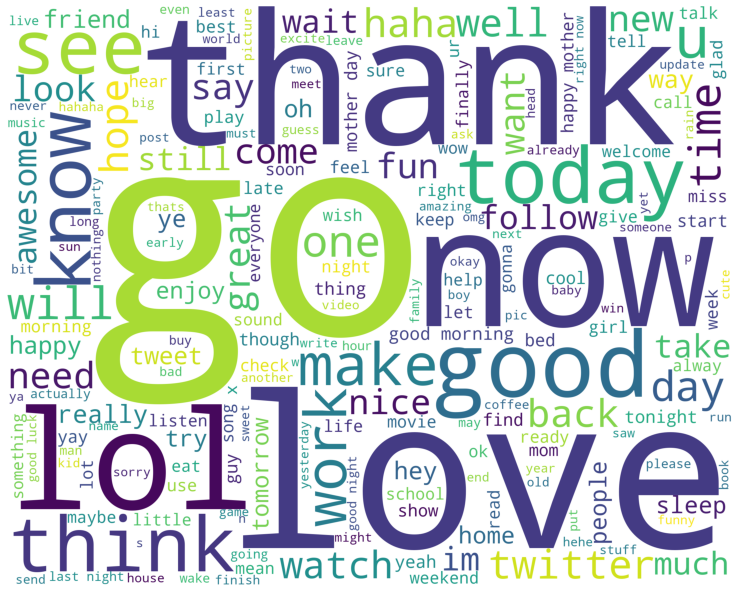

Negative words


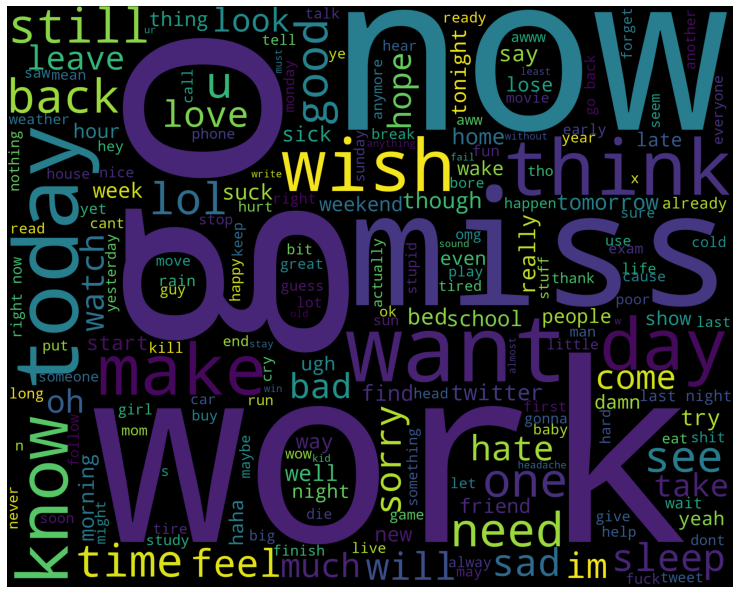

In [19]:
from wordcloud import WordCloud, STOPWORDS

positive_words = []
negative_words = []

for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(positive_words, 'white')
print("Negative words")
wordcloud_draw(negative_words)

In [38]:
train, test = train_test_split(newdf, test_size=0.2, random_state=1)
X_train = train['text'].values
X_test = test['text'].values
y_train = train['target']
y_test = test['target']

In [39]:
random.Random(140).shuffle(final_data)

trim_index = int(len(final_data) * 0.9)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

In [40]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.7564
Most Informative Features
               toothache = True                0 : 1      =     39.7 : 1.0
                     bom = True                1 : 0      =     37.0 : 1.0
               depressed = True                0 : 1      =     35.9 : 1.0
                    roni = True                0 : 1      =     35.0 : 1.0
                 unhappy = True                0 : 1      =     29.8 : 1.0
                  asthma = True                0 : 1      =     26.3 : 1.0
              depressing = True                0 : 1      =     23.4 : 1.0
                   hates = True                0 : 1      =     23.0 : 1.0
                     ftl = True                0 : 1      =     22.3 : 1.0
                  #movie = True                1 : 0      =     21.7 : 1.0
None


In [41]:
from sklearn import metrics

# Storing all desired values in a list
y = [test_data[i][1] for i in range(len(test_data))]
# Storing all probabilities of having a positive sentiment in a list
probs = [classifier.prob_classify(test_data[i][0]).prob(1) for i in range(len(test_data))]

print(len(y), len(probs))

fpr, tpr, thresholds = metrics.roc_curve(y, probs)

auc = metrics.roc_auc_score(y, probs)
print('AUC: %.3f' % auc)

40000 40000
AUC: 0.848


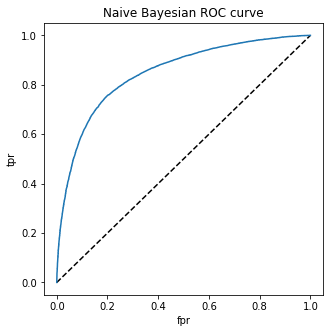

In [42]:
#Plotting the ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Naive Bayesian ROC curve')
plt.show()

In [43]:
probs = [classifier.classify(test_data[i][0]) for i in range(len(test_data))]
y = np.asarray(y)
probs = np.asarray(probs)
pd.crosstab(y, probs, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,17848,2202,20050
1,7542,12408,19950
All,25390,14610,40000


In [44]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Greens',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [45]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [46]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


              precision    recall  f1-score   support

           0       0.80      0.76      0.78     39909
           4       0.78      0.81      0.79     40091

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



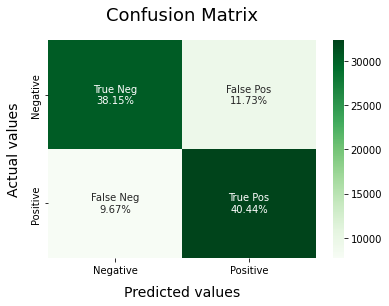

In [47]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     39909
           4       0.80      0.80      0.80     40091

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



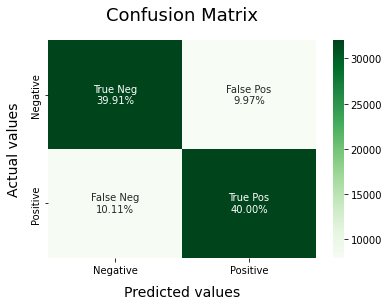

In [48]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     39909
           4       0.81      0.81      0.81     40091

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



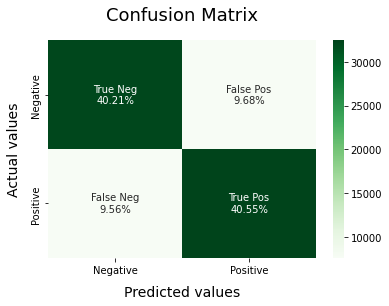

In [49]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.74      0.62      0.67     39909
           4       0.67      0.79      0.73     40091

    accuracy                           0.70     80000
   macro avg       0.71      0.70      0.70     80000
weighted avg       0.71      0.70      0.70     80000



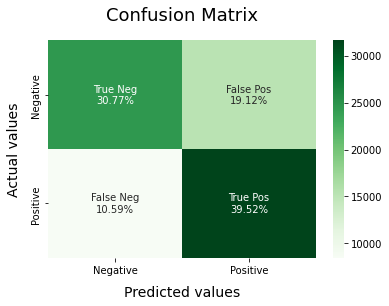

In [52]:
XGBmodel = xgb.XGBClassifier()
XGBmodel.fit(X_train, y_train)
model_Evaluate(XGBmodel)

## Logistic Regression performs the best with 81% accuracy.